In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [3]:
latent_dim = 20
batch_size = 128
learning_rate = 1e-3
epochs = 10

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

mu_p = torch.full((1, latent_dim), 5.0).to(device)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.16MB/s]


In [4]:
for epoch in range(epochs):
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(x)
        reconstruction_loss = F.binary_cross_entropy(reconstruction, x.view(-1, 784), reduction='sum') / x.size(0)
        kl_div = 0.5 * torch.sum(-logvar + torch.exp(logvar) + (mu - mu_p)**2 - 1, dim=1).mean()
        loss = reconstruction_loss + kl_div
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')


Epoch 0, Batch 0, Loss 798.6813354492188
Epoch 0, Batch 100, Loss 205.5899658203125
Epoch 0, Batch 200, Loss 164.56044006347656
Epoch 0, Batch 300, Loss 154.792236328125
Epoch 0, Batch 400, Loss 148.24200439453125
Epoch 1, Batch 0, Loss 138.36431884765625
Epoch 1, Batch 100, Loss 126.571533203125
Epoch 1, Batch 200, Loss 125.93390655517578
Epoch 1, Batch 300, Loss 124.95774841308594
Epoch 1, Batch 400, Loss 129.26821899414062
Epoch 2, Batch 0, Loss 124.249755859375
Epoch 2, Batch 100, Loss 122.29117584228516
Epoch 2, Batch 200, Loss 119.2076187133789
Epoch 2, Batch 300, Loss 122.24314880371094
Epoch 2, Batch 400, Loss 121.1983413696289
Epoch 3, Batch 0, Loss 120.14918518066406
Epoch 3, Batch 100, Loss 118.75396728515625
Epoch 3, Batch 200, Loss 122.57997131347656
Epoch 3, Batch 300, Loss 115.10966491699219
Epoch 3, Batch 400, Loss 118.60784912109375
Epoch 4, Batch 0, Loss 117.88157653808594
Epoch 4, Batch 100, Loss 116.72402954101562
Epoch 4, Batch 200, Loss 114.61698150634766
Epoch 4,

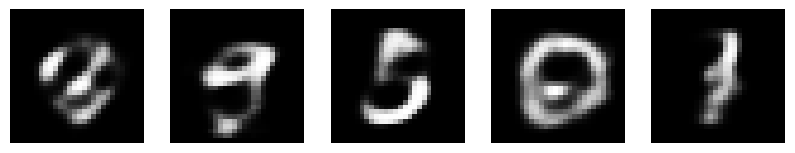

In [5]:
with torch.no_grad():
    z = torch.normal(5.0, 1.0, size=(5, latent_dim)).to(device)
    generated_images = model.decode(z).view(-1, 1, 28, 28)

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(generated_images[i].cpu().numpy().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()